In [1]:
!pip install -qq numpy
!pip install -qq opencv-python
!pip install -qq matplotlib
!pip install -qq git+https://github.com/udesa-vision/i308-utils.git

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from i308_utils import show_images, imshow
from utils_gabor import (
    anms,
    cross_check_and_lowe_match,
    extract_matched_points,
    ransac_match_filter,
    compute_homography,
    create_combined_for_plotting,
    warp_and_blend_edge_mask_three_photos
)

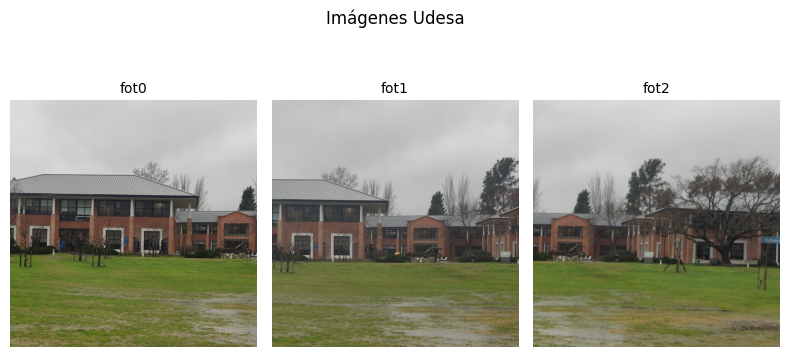

In [3]:
fot0 = cv2.imread('img/udesa_0.jpg')
fot1 = cv2.imread('img/udesa_1.jpg')
fot2 = cv2.imread('img/udesa_2.jpg')

show_images([fot0, fot1, fot2], ['fot0', 'fot1', 'fot2'], grid=(1, 3), title="Imágenes Udesa", figsize=(8, 4))

# 3.1 Detección y descripción de características

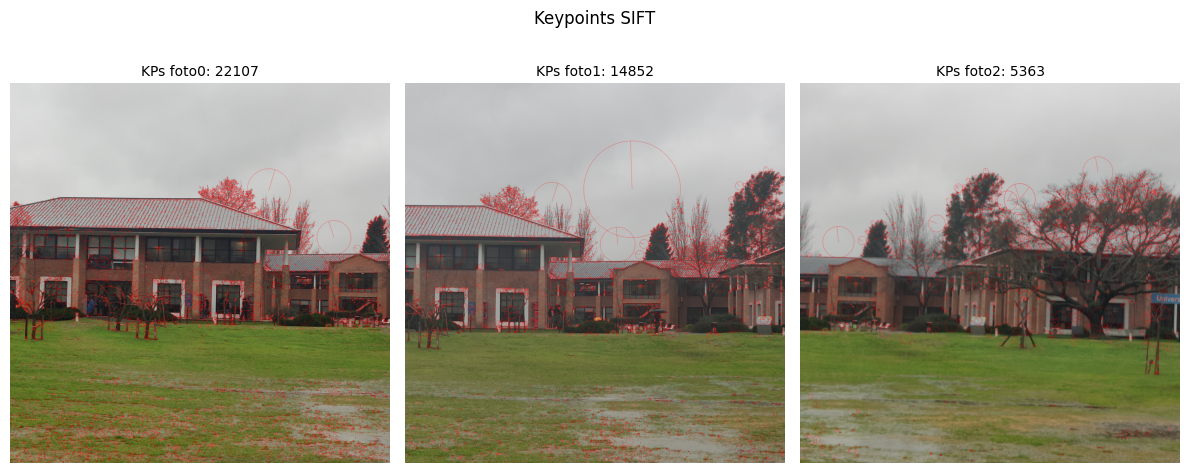

In [4]:
sift_algo = cv2.SIFT_create()
kp0, des0 = sift_algo.detectAndCompute(fot0, None)
kp1, des1 = sift_algo.detectAndCompute(fot1, None)
kp2, des2 = sift_algo.detectAndCompute(fot2, None)

fot0_con_kps = cv2.drawKeypoints(fot0, kp0, 0, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fot1_con_kps = cv2.drawKeypoints(fot1, kp1, 0, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fot2_con_kps = cv2.drawKeypoints(fot2, kp2, 0, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_images(
    [fot0_con_kps, fot1_con_kps, fot2_con_kps],
    [f"KPs foto0: {len(kp0)}", f"KPs foto1: {len(kp1)}", f"KPs foto2: {len(kp2)}"],
    grid=(1, 3),
    title="Keypoints SIFT",
    figsize=(12, 5)
)

# 3.2 Adaptive non-maximal suppression

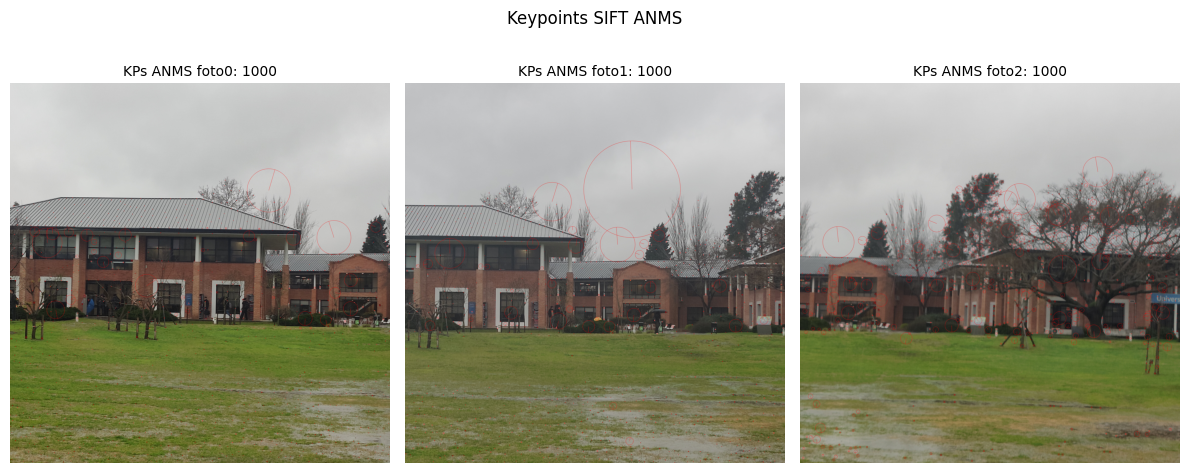

In [5]:
kp0_anms, des0_anms = anms(kp0, des0, 1000)
kp1_anms, des1_anms = anms(kp1, des1, 1000)
kp2_anms, des2_anms = anms(kp2, des2, 1000)

fot0_anms = cv2.drawKeypoints(fot0, kp0_anms, None, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fot1_anms = cv2.drawKeypoints(fot1, kp1_anms, None, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fot2_anms = cv2.drawKeypoints(fot2, kp2_anms, None, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_images(
    [fot0_anms, fot1_anms, fot2_anms],
    [f"KPs ANMS foto0: {len(kp0_anms)}", f"KPs ANMS foto1: {len(kp1_anms)}", f"KPs ANMS foto2: {len(kp2_anms)}"],
    grid=(1, 3),
    title="Keypoints SIFT ANMS",
    figsize=(12, 5)
)

# 3.3 Asociación de características

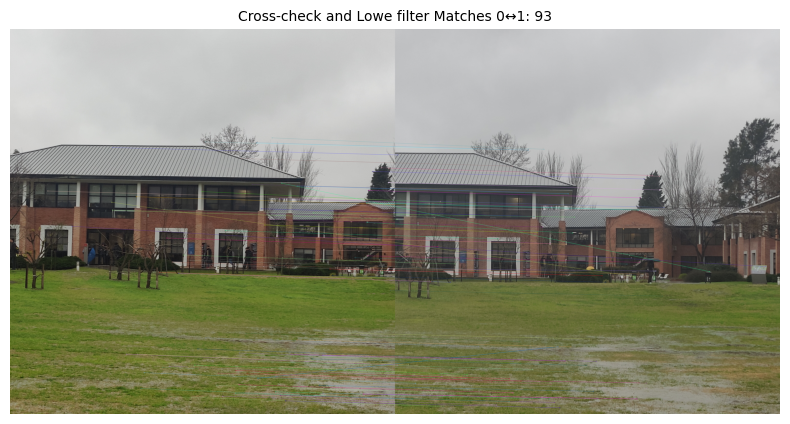

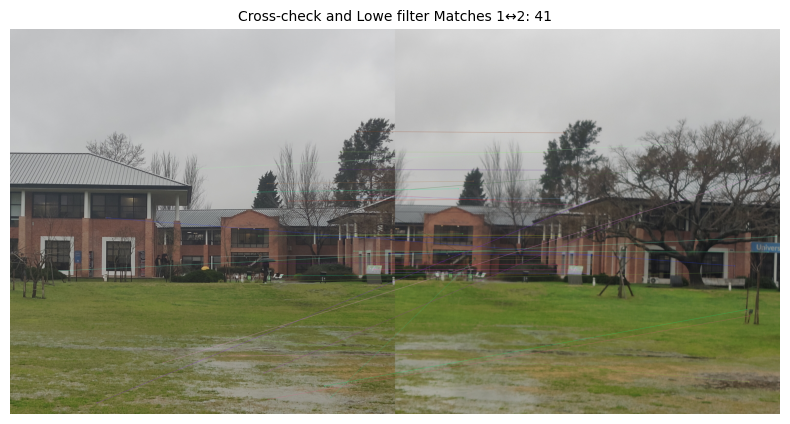

In [6]:
matches_0to1 = cross_check_and_lowe_match(des0_anms, des1_anms, lowe_ratioA=0.75, lowe_ratioB=0.75)
matches_1to2 = cross_check_and_lowe_match(des1_anms, des2_anms, lowe_ratioA=0.85, lowe_ratioB=0.85)

matched_img01 = cv2.drawMatches(fot0, kp0_anms, fot1, kp1_anms, matches_0to1, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(matched_img01, title=f"Cross-check and Lowe filter Matches 0↔1: {len(matches_0to1)}", figsize=(12, 5))

matched_img12 = cv2.drawMatches(fot1, kp1_anms, fot2, kp2_anms, matches_1to2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(matched_img12, title=f"Cross-check and Lowe filter Matches 1↔2: {len(matches_1to2)}", figsize=(12, 5))

# 3.4 Estimación manual de la homografía

In [7]:
matches_0_to_1_manual = {
    "image0": [
        [1508,915],
        [1131,1549],
        [2852,1351],
        [2516,1764],
    ],
    "image1": [
        [619,972],
        [239,1616],
        [1965,1406],
        [1641,1818],
    ]
}

pts0_manual = np.array(matches_0_to_1_manual["image0"])
pts1a_manual = np.array(matches_0_to_1_manual["image1"])

H01_manual = compute_homography(pts0_manual, pts1a_manual)
H01_manual

array([[ 1.05890334e+00,  1.17002498e-02, -9.72251719e+02],
       [ 2.04374615e-02,  1.03550589e+00,  1.92568703e+01],
       [ 1.80964889e-05, -1.08047380e-06,  1.00000000e+00]])

In [8]:
matches_2_to_1_manual = {
    "image1": [
        [1909,1420],
        [1581,1768],
        [2923,1911],
        [2754,1400],
    ],
    "image2": [
        [508,1400],
        [152,1741],
        [1494,1916],
        [1351,1407],
    ]
}

pts1b_manual = np.array(matches_2_to_1_manual["image1"])
pts2_manual = np.array(matches_2_to_1_manual["image2"])

H21_manual = compute_homography(pts2_manual, pts1b_manual)
H21_manual

array([[ 9.52549867e-01,  7.85153634e-02,  1.32693258e+03],
       [-6.04864955e-02,  1.02165733e+00,  2.91466264e+01],
       [-2.01917510e-05,  1.17229708e-05,  1.00000000e+00]])

## Stitch de panorámica con Homografías manuales

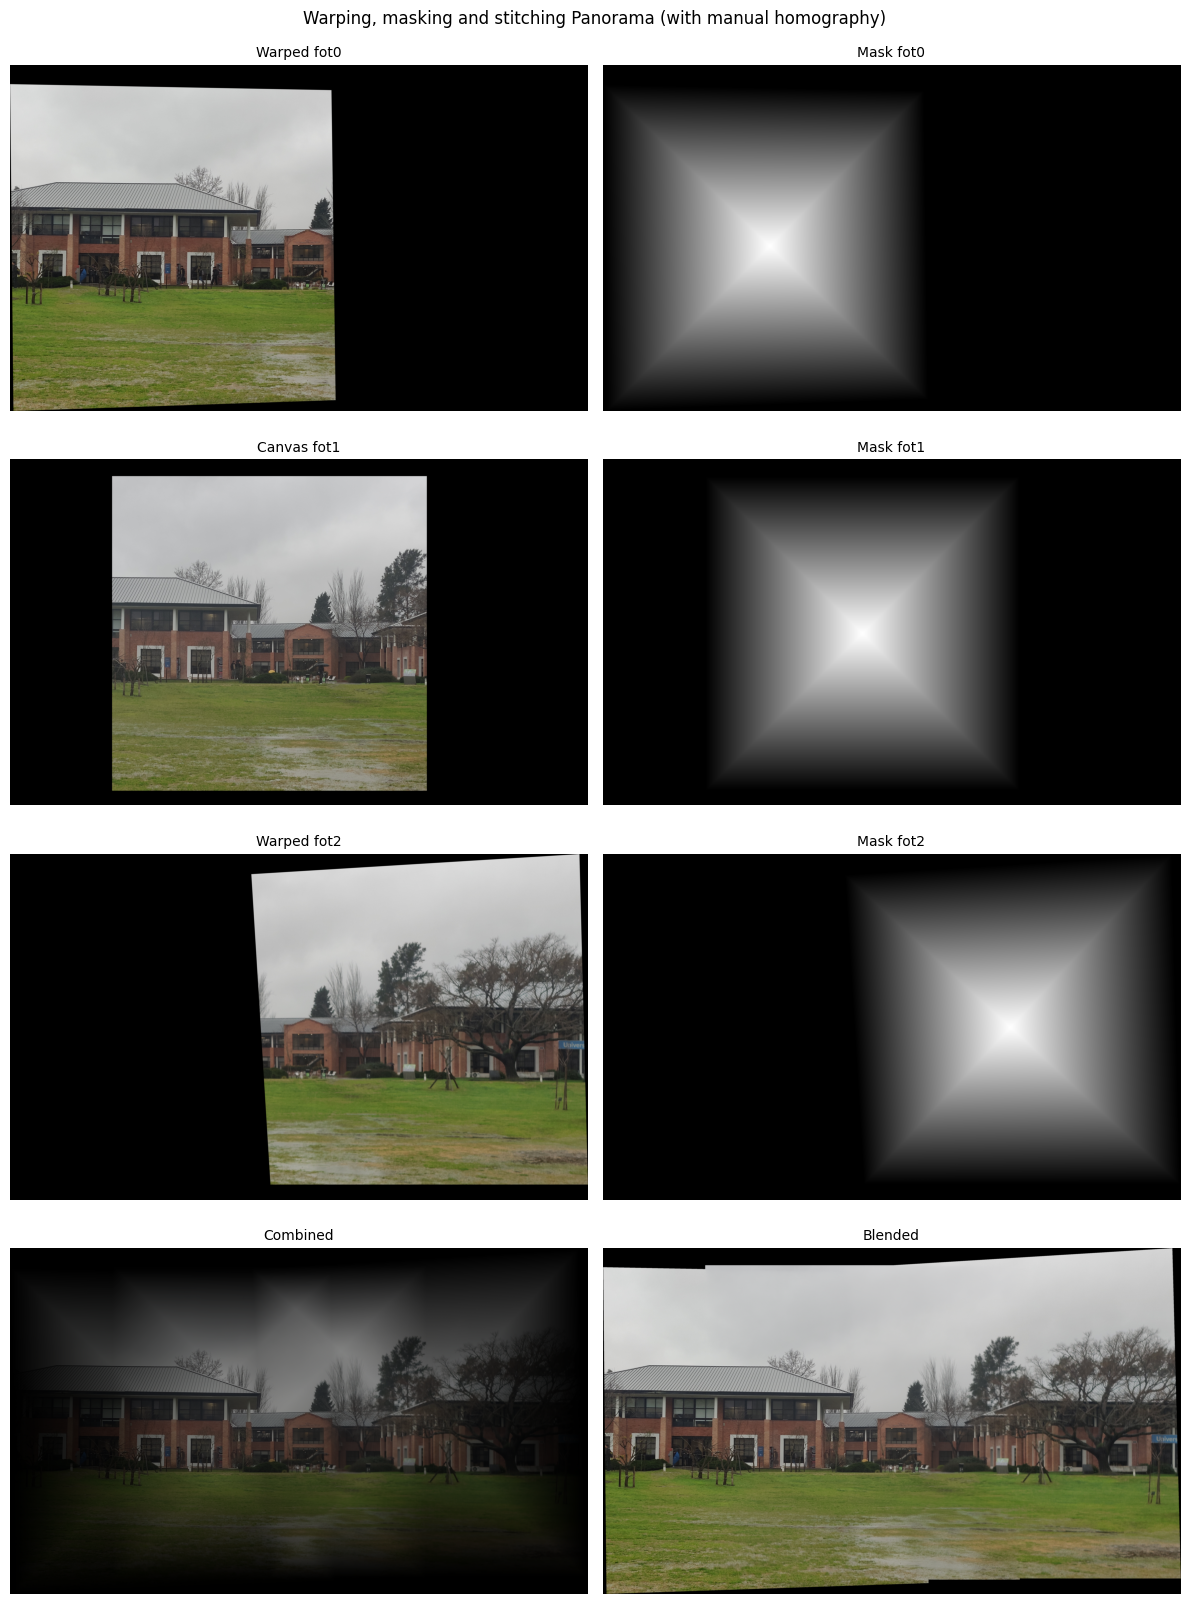

True

In [9]:
warped0_manual, canvas1_manual, warped2_manual, mask_warped0_manual, mask_canvas1_manual, mask_warped2_manual, blended_manual = \
    warp_and_blend_edge_mask_three_photos(fot0, fot1, fot2, H01_manual, H21_manual)

combined_manual = create_combined_for_plotting(warped0_manual, mask_warped0_manual, canvas1_manual, mask_canvas1_manual, warped2_manual, mask_warped2_manual)

show_images(
    [warped0_manual, mask_warped0_manual, canvas1_manual, mask_canvas1_manual, warped2_manual, mask_warped2_manual, combined_manual, blended_manual],
    ["Warped fot0", "Mask fot0", "Canvas fot1", "Mask fot1", "Warped fot2", "Mask fot2", "Combined", "Blended"],
    grid=(4, 2),
    title="Warping, masking and stitching Panorama (with manual homography)",
    figsize=(12, 16),
)

cv2.imwrite("img/panorama_combined_ransac.jpg", blended_manual)

# 3.5 RANSAC + estimación algorítmica de homografías

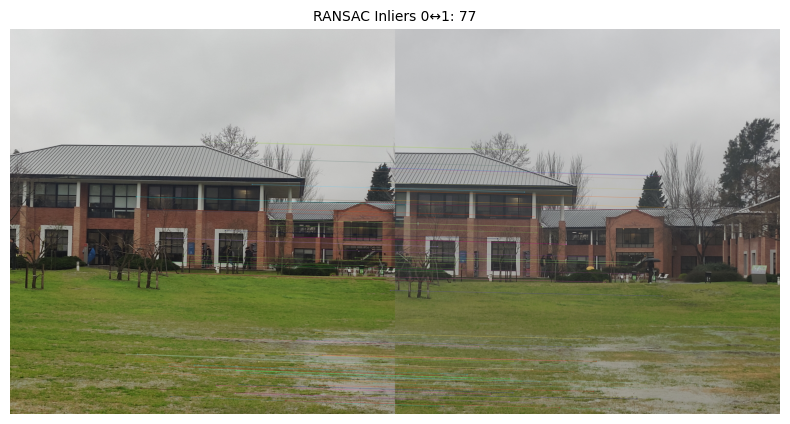

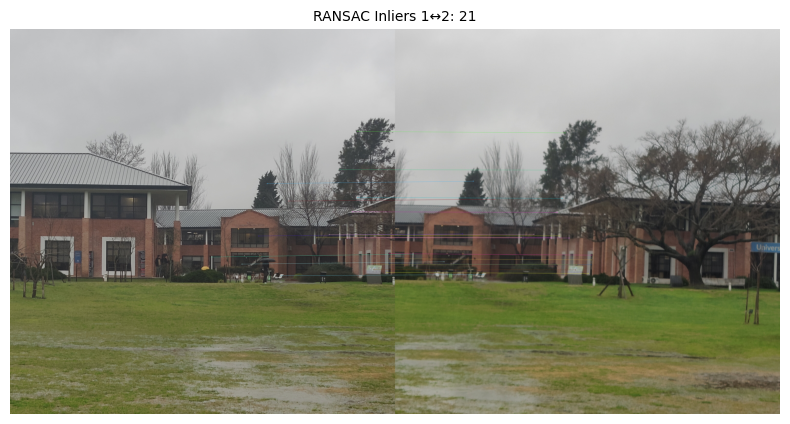

In [10]:
pts0, pts1a = extract_matched_points(kp0_anms, kp1_anms, matches_0to1)
mask01 = ransac_match_filter(pts0, pts1a, threshold=5.0, max_iter=1000)
inlier_matches01 = [m for i, m in enumerate(matches_0to1) if mask01[i]]
fot0_fot1_inliers = cv2.drawMatches(fot0, kp0_anms, fot1, kp1_anms, inlier_matches01, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(fot0_fot1_inliers, title=f"RANSAC Inliers 0↔1: {len(inlier_matches01)}", figsize=(12, 5))

pts1b, pts2 = extract_matched_points(kp1_anms, kp2_anms, matches_1to2)
mask12 = ransac_match_filter(pts1b, pts2, threshold=5.0, max_iter=1000)
inlier_matches12 = [m for i, m in enumerate(matches_1to2) if mask12[i]]
fot1_fot2_inliers = cv2.drawMatches(fot1, kp1_anms, fot2, kp2_anms, inlier_matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(fot1_fot2_inliers, title=f"RANSAC Inliers 1↔2: {len(inlier_matches12)}", figsize=(12, 5))

In [11]:
H_ransac_01, _ = cv2.findHomography(pts0[mask01], pts1a[mask01], 0)
H_ransac_21, _ = cv2.findHomography(pts2[mask12], pts1b[mask12], 0)

## Stitch de panorámica con Homografías RANSAC

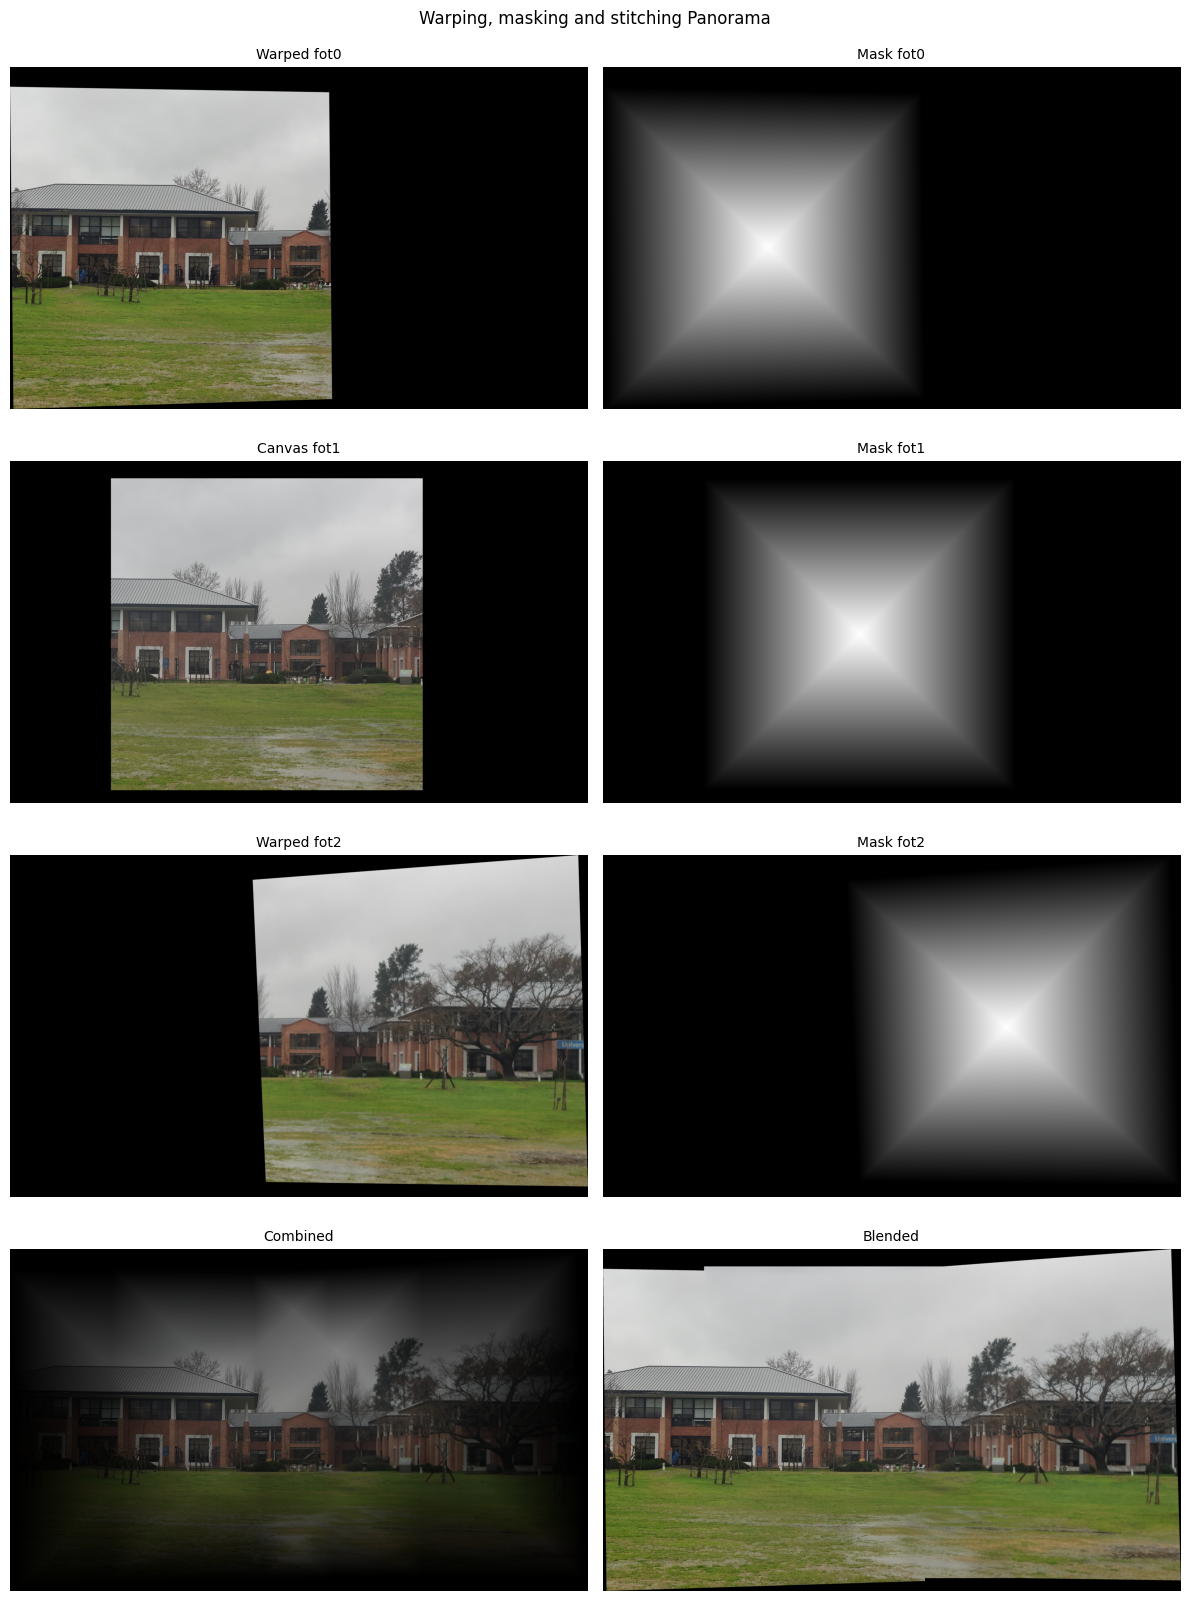

True

In [12]:
warped0, canvas1, warped2, mask_warped0, mask_canvas1, mask_warped2, blended = warp_and_blend_edge_mask_three_photos(fot0, fot1, fot2, H_ransac_01, H_ransac_21)

combined = create_combined_for_plotting(warped0, mask_warped0, canvas1, mask_canvas1, warped2, mask_warped2)

show_images(
    [warped0, mask_warped0, canvas1, mask_canvas1, warped2, mask_warped2, combined, blended],
    ["Warped fot0", "Mask fot0", "Canvas fot1", "Mask fot1", "Warped fot2", "Mask fot2", "Combined", "Blended"],
    grid=(4, 2),
    title="Warping, masking and stitching Panorama",
    figsize=(12, 16),
)

cv2.imwrite("img/panorama_combined_ransac.jpg", blended)